<h1>Protein secondary structure prediction using bidirectional LSTM networks</h1>

In [118]:
training = False

In [119]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence

<h2> 1. Introduction </h2>

Proteins are large biomolecules that can be found in all biological organisms. They have a vast array of biological functions e.g. DNA replication, responding to stimuli and catalysing metabolic reactions. Proteins consist of amino acid chains called polypeptides. The folded form of a polypeptide is called the secondary structure of a protein. These folded polypeptides can bind together to from the tertiary structure of a protein. In total there are 20 different standard amino acids. The amino acids in the polypeptide chains interact with each other and form a secondary structure which is a three-dimensional structure that sets the proteins function. For example the secondary structure can be a binding site for a specific biomolecule which can catalyze the reaction of said molecule.

It has been a huge interest in biochemical research to find a way to predict the secondary structure of an amino acid chain. If the secondary structure could be predicted it would be possible to engineer proteins for specific reactions. This would revolutionize the enzyme industry since we could create custom catalytes for different chemical reactions. However, the prediction is not an easy task. There has been a variety of methods that have been used to solve this problem in the past sixty-five years. In the past decade deep learning models have been performing very well. [1]

In this project I'm applying a bidirectional Long-short-term memory on a dataset that has information about secondary structures of amino acid sequences. In general obtaining such data is slow and expensive. This is due to the nature of methods used to get protein features including X-ray and Nuclear Magnetic Resonance. In addition to the industrial uses of the structure prediction it can also be used to get a better understanding of the functions of a cell.

In [120]:
# Helper functions

def to_categorical(y, num_classes):
    # 1-hot encodes a tensor
    out = np.eye(num_classes, dtype='uint8')[y]
    return torch.from_numpy(out).long()

def sequence_to_ngram(seqs, n = 3):
    # Creates n-grams of length n for sequences in seqs
    ngrams = np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])
    return ngrams

def pad_tensors(seqs, targets, seq_dict, target_dict, context_size):
    # Adds padding to both sequence and target tensors
    # Padding value is 0 and all tensors are padded to the length of the longest
    # Tensor in the group i.e. if maxlen is 32 all tensors will have length 32.
    
    tensors = []
    goal_tensors = []
    for i in range(len(seqs)):
        seq_tensor = torch.tensor([seq_dict[x] for x in seqs[i]], dtype = torch.long)
        goal_tensor = torch.tensor([target_dict[y] for x in targets[i] for y in x], dtype = torch.long)
        tensors.append(seq_tensor)
        goal_tensor = to_categorical(goal_tensor, context_size)
        goal_tensors.append(goal_tensor)
    padded_seqs = pad_sequence(tensors, batch_first = True)
    goal_tensors = pad_sequence(goal_tensors, batch_first = True)
    return padded_seqs, goal_tensors

def fix_ones(target):
    # This is used to add 1s to resemble the padding values
    # So that the model will learn to find the end of sequence
    for row in target:
        if max(row) == 0:
            row[0] = 1
    return target

<h2> 2. Data </h2>

The data is protein secondary structure data from the RCBS Protein Data Bank (https://www.rcsb.org/). The dataset that I used was hosted at Kaggle: https://www.kaggle.com/alfrandom/protein-secondary-structure. These protein structures are obtained with X-ray or NMR methods which find the 3D coordinates of each atoms in the molecule. These can be used to solve the 3D structure of the protein.

The protein structure can be modeled by using eight different structure types or states provided by DSSP software [2]. Each amino acid is assigned to one of the eight structure types so that the structural sequences are of equal length as the amino acid sequences. The eight structure types are:

<h3> Q8 model </h3>
1. **C**: Loops and irregular elements
2. **E**: β-strand
3. **H**: α-helix
4. **B**: β-bridge
5. **G**: 3-helix
6. **I**: π-helix
7. **T**: Turn
8. **S**: Bend

It is common to group some of the structure types for more simple prediction. We can group these eight states to three states:

<h3> Q3 model </h3>
1. **E**: E and B
2. **H**: H, G and I
3. **C**: C, S and T

The dataset has 7 columns: *pbd_id* (Unique identifier for a protein sequence), *chain_code* (Used to locate a certain peptide in a case where protein consists of multiple peptides), *seq* (Amino acid sequence), *sst8* (Q8 structure of the sequence), *sst3* (Q3 structure of the sequence), *len* (length of the sequence) and *has_nonstd_aa* (Boolean wether the protein sequence has non-standard amino acids.

These values are used to filter the data and as the actual features. The goal is to predict either *sst3* or *sst8* from *seq*. The sequences are filtered by *len* and *has_nonstd_aa*. I trained the model for Q3 and Q8 structure types for two different lengths: smaller than 32 and smaller than 128. Sequences with nonstd amino acids were always discarded.

Here is a small description of the data. The figure shows the distribution of sequence lengths and the red line is the length cutoff used for this project:


  pdb_id chain_code  seq sst8 sst3  len  has_nonstd_aa
0   1A30          C  EDL  CBC  CEC    3          False
1   1B05          B  KCK  CBC  CEC    3          False
2   1B0H          B  KAK  CBC  CEC    3          False
3   1B1H          B  KFK  CBC  CEC    3          False
4   1B2H          B  KAK  CBC  CEC    3          False
Max length: 5037, Minimum length: 3


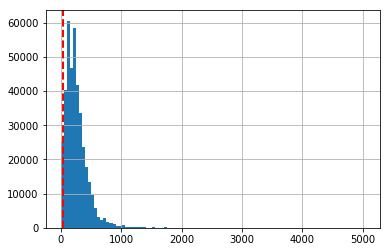

In [121]:
df = pd.read_csv("data/2018-06-06-ss.cleaned.csv")

# Describring and visualizing the data

print(df.head())
print(f"Max length: {max(df.len)}, Minimum length: {min(df.len)}")

df.pdb_id.describe()

# Maximum sequence length can be 32 (small set) or 128 (larger set)
max_len = 32
#max_len = 128

df.len.hist(bins = 100)
plt.axvline(x=max_len, color='r', linestyle='dashed', linewidth=2)

<h3> 2.1 Preprocessing </h3>

To increase the vocabulary size and to get a better understanding of how the amino acids are generally ordered in the sequences I use n-grams. N-grams have been widely used in biological context for different sequence data from 80s to modern day [3,4]. I use n-grams of length 3 which can be formulated in the following way:

$Ngram(S_a) = S_a + S_{a+1} + S_{a+2}$

where $S$ is the amino acid sequence and $a$ is an index of an amino acid. If $a+1 \mbox{ or } a+2  > \mbox{len(S)} \ , \ S_{a+1} = \emptyset$ 

By doing this for all the sequences we can increase the vocabulary size from 20 to 8420. This will increase the prediction accuracy significantly.

The filtered data is split into test and train sets and the size of the test set is 20% of the size of the whole dataset. 

A dictionary for the amino acid triplets and for the structural states has to be created to be able to feed the data into a network. The sequences are represented as a tensor of integers and the structure as a one-hot coded matrix of size: $\mbox{sequence length} \times \mbox{categories + 1}$.

The tensors are padded with zeros so that they are of equal length. In this case the max length is either 32 or 128.

In [122]:
# States variable decides if the three-state or eight-state model will be used

states = 'sst3'
#states = 'sst8'

# Context size is amount of states + 1 because of the padding value
if states == 'sst3':
    context_size = 4
elif states == 'sst8':
    context_size = 9

# Filter the dataframe to get only seqs smaller than maxlen and remove seqs with nonstd aminoacids
input_seqs, target_seqs = df[['seq', states]][(df.len <= max_len) & (~df.has_nonstd_aa)].values.T

# Expand the sequence corpus by applying a sliding overlapping window
ngrams = sequence_to_ngram(input_seqs)

# Set up sequence and target dictionaries

seq_dict = {}
count = 1
for i in ngrams:
    for j in i:
        if j not in seq_dict.keys():
            seq_dict[j] = count
            count += 1

c = 1
target_dict = {}
for i in target_seqs:
    for j in i:
        if j not in target_dict.keys():
            target_dict[j] = c
            c += 1

# Split into test and train
seq_train, seq_test, target_train, target_test = train_test_split(ngrams, target_seqs, 
                                                                  test_size = 0.2, random_state = 0)
# Save the original input seqs with same partition for later
input_train, input_test, _, _ = train_test_split(input_seqs, target_seqs, test_size = 0.2, random_state = 0)

# Create padded tensors
seq_train, target_train = pad_tensors(seq_train, target_train, seq_dict, target_dict, context_size)
seq_test, target_test = pad_tensors(seq_test, target_test, seq_dict, target_dict, context_size)

# See the amount of states and amount of amino acid triplets in out dataset
print(len(target_dict))
print(len(seq_dict))

3
7838


<h2> 3. Models </h2>

For this task I chose to use Long short term memory (LSTM) network since it works well with sequential data. Since the sequence data is not typical natural language data and the relationships between the aminoacids should be concidered in both directions I chose to use a Bidirectional LSTM. Bidirectional-LSTM is very similar to a normal LSTM. Instead of using only past features it uses also the future features. [5]

The network architecture used is as follows (left side is tensor shape and right side is a function applied between layers):


![](bi-LSTM.png)

The loss function I used was Categorical Cross-Entropy Loss which is widely used loss function for multiclass classification. I tried the model with different hyperparameters and the best results came with following combination:
- Learning rate: 0.05
- Embedding_dim: max_length of sequences
- Hidden_dim: max_lengt of sequences

In total I used four different models:
1. Short sequences (max_len = 32) with three-state structure
2. Long sequences (max_len = 128) with three-state structure
3. Short sequences (max_len = 32) with eigth-state structure
4. Long sequences (max_len = 128) with eigth-state structure

Out of these models the three-state models have been used previously for this problem but the eight-state model has not. It is interesting to see which factors have the largest effect on the results.

These models were trained with the whole train-set. Training used 10 epochs with batch size 1.

In [123]:
# Neural network model
class NGramModel(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, context_size):
        super(NGramModel, self).__init__()
        self.hidden_dim = hidden_dim        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embed the input sequence
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, bidirectional = True, num_layers = 1) # Bidirectional LSTM layer
        self.dropout = nn.Dropout(0.1) # Dropout of the LSTM layer
        self.lin = nn.Linear(hidden_dim, context_size) # Linear layer to map output to context_size dimensions
        
    def forward(self, inputs):
        embeds = self.embedding(inputs)
        out, states = self.lstm(embeds.view(1, len(inputs), -1))
        out = self.dropout(out)
        out = self.lin(out.view(1,len(inputs), -1))
        out = F.log_softmax(out, dim = 2)
        out = out.view(len(inputs),-1)
        return(out)
        

In [124]:
learning_rate = 0.05
vocab_size = len(seq_dict) + 1

losses = []
loss_f = nn.CrossEntropyLoss()
model = NGramModel(max_len, max_len, vocab_size, context_size)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

if training == True:
    for epoch in range(10):
        total_loss = 0
        i = 0
        print(f"Starting epoch number {epoch}")
        for seq in seq_train:
            model.zero_grad()
            log_probs = model(seq)

            target = target_train[i]
            target = fix_ones(target)

            loss = loss_f(log_probs, torch.max(target,1)[1])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            i += 1

            if i % 10000 == 0:
                print(f"epoch: {epoch} , i: {i}")
        print(total_loss)
        losses.append(total_loss)
    print(losses)
    #torch.save("test_model.pth")
else:
    # Load the model that fits the state and maxlen values
    if max_len == 32 and states == 'sst3':
        model = torch.load("LSTM_model_proper_3_state_small.pth")
    elif max_len == 32 and states =='sst8':
        model = torch.load("LSTM_model_proper_8_state_small.pth")
    elif max_len == 128 and states == 'sst3':
        model = torch.load("LSTM_model_proper.pth")
    elif max_len == 128 and states == 'sst8':
        model = torch.load("LSTM_model_proper_8_state.pth")
    else:
        pass
    model.eval()

<h2> 4. Results </h2>

Here are the prediction accuracies for the four models described above. 

| Model        | Prediction accuracy (test) | Prediction accuracy (train)  |
| ------------ |:--------------------------:| ----------------------------:|
| Model 1      |                      0.786 |                        0.794 |
| Model 2      |                      0.690 |                        0.697 |
| Model 3      |                      0.624 |                        0.625 |
| Model 4      |                      0.501 |                        0.500 |

Belove are visualizations of comparisons between actual structure and predicted structure for five examples using model 1 on test data.

---
Input:      ETREQRAIRLARMSAYAARRLAN
Target:     CCHHHHHHHHHCCCCCCCCCCCC
Prediction: CCCHCHCCHHCCCCHCCCHHCCC


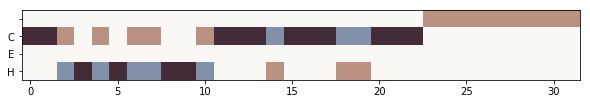

Accuracy: 0.75
---
Input:      GHRP
Target:     CECC
Prediction: CECC


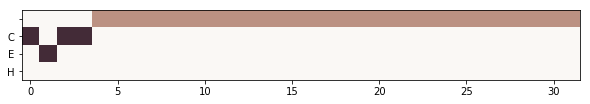

Accuracy: 1.0
---
Input:      FVNQHLCGSHLVEALYLVCGERGFFYTPKT
Target:     CCCECCCCHHHHHHHHHHHHHHCEEECCCC
Prediction: CCCHCCCCHHHHHHHHHHHHHHCEEECCCC


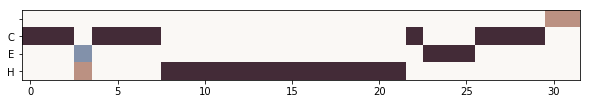

Accuracy: 0.96875
---
Input:      DGVFTTPCDPEYAGG
Target:     CCCCCCCCCCCCCCC
Prediction: CCCCECCCCCHCCCC


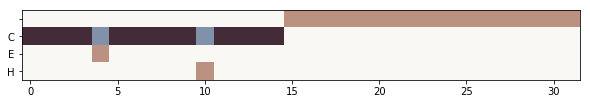

Accuracy: 0.9375
---
Input:      FVNQHLCGSHLVEALYLVCGERGFFYTPKT
Target:     CECCCCCCCCCCCCEECCCCCCCCCCCCCC
Prediction: CCCHCCCCHHHHHHHHHHHHHHCEEECCCC


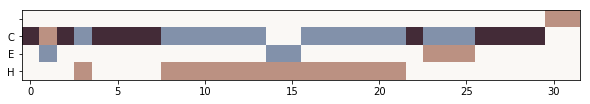

Accuracy: 0.40625
Mean prediction accuracy (test): 0.7860973428985734
Mean prediction accuracy (train): 0.7939385325828787


In [133]:
# Dicts used to convert category values to sequence or state values
rev_seq_dict = {value:key for key, value in seq_dict.items()}
rev_target_dict = {value:key for key, value in target_dict.items()}

def pred_to_onehot(pred):
    # Turns the category probability matrix into onehot
    out = np.zeros_like(pred)
    out[np.arange(len(pred)), pred.argmax(1)] = 1
    return out

def onehot_to_seq(onehot_seq, index_dict):
    # Truens the onehot matrix into predicted structure sequence
    seq = ''
    for o in onehot_seq:
        max_i = np.argmax(o)
        if max_i != 0:
            seq += index_dict[max_i]
        else:
            break
    return seq

def plot_results(x, y, y_):
    # Plots the comparison between actual structure and the predicted structure
    # Predicted structure is orange and actual structure blue
    # If the blue and orange overlap it means that prediction == actual for that amino acid
    # The upmost value means sequence end
    print("---")
    print("Input:      " + str(x))
    print("Target:     " + str(onehot_to_seq(y, rev_target_dict).upper()))
    print("Prediction: " + str(onehot_to_seq(y_, rev_target_dict).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Oranges', alpha=.5)
    plt.yticks(range(4), [' '] + [rev_target_dict[i+1].upper() for i in range(3)])
    plt.show()

def full_accuracy(test, target):
    # Counts the full test accuracy for the whole test set
    accuracies = []
    for i in range(len(test)):
        outputs = model(test[i])
        pred = pred_to_onehot(outputs.detach().numpy())
        pred = np.argmax(pred,1)
        actual = np.argmax(target[i],1).numpy()
        pred = pred[pred != 0]
        actual = actual[actual != 0]
        acc = accuracy_score(pred, actual)
        accuracies.append(acc)
    return np.mean(accuracies)

# Amount of examples to be visualized
n = 5

test = seq_test[:n]
i_test = input_test[:n]
target = target_test[:n]

mean_acc = 0

for i in range(len(test)):
    outputs = model(test[i])
    pred = pred_to_onehot(outputs.detach().numpy())
    plot_results(input_test[i], target[i].numpy(), pred)
    pred = np.argmax(pred,1)
    actual = np.argmax(target[i],1).numpy()
    acc = accuracy_score(pred, actual)
    print(f'Accuracy: {acc}')
    mean_acc += acc

mean_acc = mean_acc / (i+1)
print(f'Mean prediction accuracy (test): {full_accuracy(seq_test, target_test)}')
print(f'Mean prediction accuracy (train): {full_accuracy(seq_train, target_train)}')


<h2> 5. Discussion </h2>

The model with smaller sequence length and less states performed the best and the model with higher sequence length and more states performed the worst. By looking at the results we can see that both increasing sequence length and increasing possible states made the prediction more difficult. It seems like increasing the sequence length had a bit higher impact than increasing amount of states.

In comparison to another implementation of similar network my network performed a bit worse. The other implementation had test accuracy of 0.8679 for model similar to my model 1. [6]

By comparing the test and train accuracies we can see that there is little difference. It seems like there was little to none overfitting. 

Models that I used performed decently compared to the best ones around. Further steps to improve would be to make a more complicated network structure that could be able to learn the features even better and to improve the hyperparameter estimation.

Protein secondary structure prediction remains as an interesting and difficult topic in computational biology. It is interesting to see how much the prediction accuracy will increase in the future while even better methods are developed. 


<h2> References </h2>

[1] Yang, Yuedong et al. “Sixty-five years of the long march in protein secondary structure prediction: the final stretch?.” Briefings in bioinformatics vol. 19,3 (): 482-494. doi:10.1093/bib/bbw129

[2] Wouter G Touw, Coos Baakman, Jon Black, Tim AH te Beek, E Krieger, Robbie P Joosten, Gert Vriend.: A series of PDB related databases for everyday needs.
Nucleic Acids Research 2015 January; 43(Database issue): D364-D368. https://swift.cmbi.umcn.nl/gv/dssp/index.html

[3] Erhan, S & Marzolf, T & Cohen, L. (1980). Amino-acid neighborhood relationships in proteins. Breakdown of amino-acid sequences into overlapping doublets, triplets and quadruplets. International journal of bio-medical computing. 11. 67-75. 10.1016/0020-7101(80)90007-0. 

[4] Coin L, Bateman A, Durbin R. Enhanced protein domain discovery by using
language modeling techniques from speech recognition. Proc Natl Acad Sci USA 2003; 100: 4516-20

[5] Z. Huang, W. Xu, and K. Yu.  Bidirectional LSTM-CRF models for sequence tagging. CoRR,abs/1508.01991, 2015.

[6] https://www.kaggle.com/helmehelmuto/u-nets-are-the-shit
